In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [18]:
import numpy as np
import matplotlib.pyplot as mpl
import obspy as op
import glob
import os
import shutil
import fnmatch
import shutil
import matplotlib.gridspec as gridspec
from scipy import fftpack
from scipy import signal
from obspy.taup import TauPyModel
from itertools import compress
import time
from IPython import display


<h2 align="center">Rotação dos sistema de coordenadas em relação ao backazimute</h2>

*Devido a um problema com a rotação do OBSPY, a rotação do sistema de coordenadas foi feito pelo SAC antes da organização e do pré-processamento dos dados.

In [155]:
os.chdir('/home/diogo/dados_doutorado/nbla-2012/')
os.system('./rotatetogcp.sh')

0

<h1 align="center">Organizando os arquivos da Estação NBLA</h1>

<h4>Renomeando os arquivos</h4>

In [156]:
EvList_rawE = []
EvList_rawN = []
EvList_rawZ = []
EvList_rawR = []
EvList_rawT = []

EvList_rawES = []
EvList_rawNS = []
EvList_rawZS = []
EvList_rawRS = []
EvList_rawTS = []

for root, dirs, files in os.walk('/home/diogo/dados_doutorado/nbla-2012/'):
    for EVfile in files:
        if EVfile.endswith('.e'):
            EvList_rawE.append(os.path.join(root, EVfile))
        if EVfile.endswith('.n'):
            EvList_rawN.append(os.path.join(root, EVfile))
        if EVfile.endswith('.z'):
            EvList_rawZ.append(os.path.join(root, EVfile))
        if EVfile.endswith('.r'):
            EvList_rawR.append(os.path.join(root, EVfile))
        if EVfile.endswith('.t'):
            EvList_rawT.append(os.path.join(root, EVfile))
            
EvList_rawES = sort(EvList_rawE)
EvList_rawNS = sort(EvList_rawN)
EvList_rawZS = sort(EvList_rawZ)
EvList_rawRS = sort(EvList_rawR)
EvList_rawTS = sort(EvList_rawT)

In [157]:
EvList_Eraw1 = [i.split('.e')[0] for i in EvList_rawES]
EvList_name = [i.split('_')[2] for i in EvList_Eraw1]

In [158]:
EvList_E = ['/home/diogo/dados_doutorado/nbla-2012/NBLA.BHE.'+i+'.sac' for i in EvList_name]
EvList_N = ['/home/diogo/dados_doutorado/nbla-2012/NBLA.BHN.'+i+'.sac' for i in EvList_name]
EvList_Z = ['/home/diogo/dados_doutorado/nbla-2012/NBLA.BHZ.'+i+'.sac' for i in EvList_name]
EvList_R = ['/home/diogo/dados_doutorado/nbla-2012/NBLA.BHR.'+i+'.sac' for i in EvList_name]
EvList_T = ['/home/diogo/dados_doutorado/nbla-2012/NBLA.BHT.'+i+'.sac' for i in EvList_name]

In [159]:
for i in range(len(EvList_rawES)):
    shutil.move(EvList_rawES[i],EvList_E[i])
    shutil.move(EvList_rawNS[i],EvList_N[i])
    shutil.move(EvList_rawZS[i],EvList_Z[i])
    shutil.move(EvList_rawRS[i],EvList_R[i])
    shutil.move(EvList_rawTS[i],EvList_T[i])

<h4 align="center">Criando as pastas para organizar os arquivos da Estação NBLA de acordo com o nome do evento</h4>

In [160]:
for i in EvList_name:
    os.mkdir('/home/diogo/dados_doutorado/nbla-2012/'+str(i))

<h4 align="center">Movendo os arquivos para as pastas dos eventos</h4>

In [161]:
for i,j in enumerate(EvList_name):
    shutil.move(EvList_E[i],'/home/diogo/dados_doutorado/nbla-2012/'+str(j))
    shutil.move(EvList_N[i],'/home/diogo/dados_doutorado/nbla-2012/'+str(j))
    shutil.copy(EvList_Z[i],'/home/diogo/dados_doutorado/nbla-2012/'+str(j))

<h4 align="center">Criando as pastas para organizar os arquivos rotacionados da Estação NBLA de acordo com o nome do evento</h4>

In [162]:
for i in EvList_name:
    os.mkdir('/home/diogo/dados_doutorado/nbla-2012/'+str(i)+'/rotate')

In [163]:
for i,j in enumerate(EvList_name):
    shutil.move(EvList_R[i],'/home/diogo/dados_doutorado/nbla-2012/'+str(j)+'/rotate')
    shutil.move(EvList_T[i],'/home/diogo/dados_doutorado/nbla-2012/'+str(j)+'/rotate')
    shutil.move(EvList_Z[i],'/home/diogo/dados_doutorado/nbla-2012/'+str(j)+'/rotate')

<h3 align="center">Calculando o valor do parâmetro do raio (p) para cada evento</h3>

In [164]:
NBLAlist = []
NBLAlistS = []

for root, dirs, files in os.walk('/home/diogo/dados_doutorado/nbla-2012/'):
    for EVfile in files:
        if EVfile.endswith('.sac'):
            NBLAlist.append(os.path.join(root, EVfile))
NBLAlistS = sort(NBLAlist)

<h4>Lendo os arquivos das componentes HNZ dos eventos</h4>

In [165]:
NBLA_HNZ = []

for i in NBLAlistS:
    NBLA_HNZ += op.read(i)

<h4>Calculando o valor do parâmetro do raio (p) </h4>

In [166]:
PR_s_km = []
model = TauPyModel(model="iasp91")

for i,j in enumerate(NBLA_HNZ):
    arrivals = model.get_travel_times(source_depth_in_km=j.stats.sac.evdp,distance_in_degree=j.stats.sac.gcarc, phase_list=["P"])
    arr = arrivals[0]
    PR = arr.ray_param/6371
    PR_s_km.append(PR)

<h4>Salvando o valor do parâmetro do raio (p) na variável user8 </h4>

In [167]:
for i,j in enumerate(NBLA_HNZ):
    j.stats.sac['user8']=PR_s_km[i]
    j.write(NBLAlistS[i],format='SAC')

<h1 align="center">Pré-processamento dos dados</h1>

<h3 align="center">Removendo a tendência linear, aplicando o "taper", filtrando através dos filtros passa-baixa e passa-alta e reamostrando cada traço de cada evento</h3>

In [168]:
for i,j in enumerate(NBLA_HNZ):
    j.detrend() #tendêndia linear
    j.taper(type='hamming',max_percentage=0.02) #taper
    j.filter('lowpass',freq=4,zerophase=True) #filtro passa-baixa 4 hz
    j.filter('highpass',freq=0.05,zerophase=True)  #filtro passa-alta 0.05 hz
    #j.decimate(10) #reamostragem para 10 hz
    j.write(NBLAlistS[i],format='SAC')

<h4 align="center">Plotando exemplo de traços após o pré-processamento dos dados</h4>

In [169]:
exm_pos = op.read('/home/diogo/dados_doutorado/nbla-2012/2012.006.18.54.39.31/NBLA.BHE.2012.006.18.54.39.31.sac')
exm_pre = op.read('/home/diogo/dados_doutorado/nbla-2012_backup/NBLA_2012.006.18.54.39.31.e')

<h4>Traço sem o pré-processamento</h4>

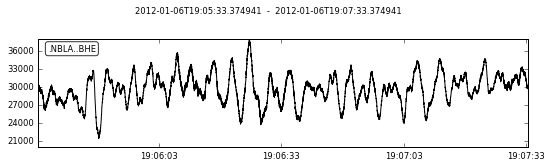

In [170]:
exm_pre.plot()

<h4>Traço com o pré-processamento</h4>

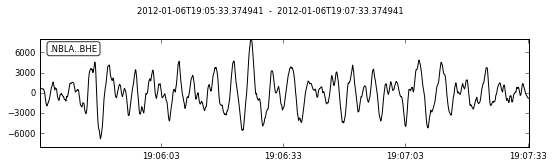

In [173]:
exm_pos.plot()

<h2 align="center">Rotação dos sistema de coordenadas em relação ao backazimute</h2>

<h2 align="center">Não foi utilizado devido a um problema na rotação do OBSPY</h2>

<h4>Rotacionando os traços rotacionados</h4>

In [ ]:
for i in EvList_name:
    os.mkdir('/home/diogo/dados_doutorado/nbla-2012/'+str(i)+'/rotate')

In [ ]:
NBLARTZlist =  [i.split('.') for i in NBLAlistS]
NBLAe_2 = [NBLARTZlist[i][7:] for i in range(len(NBLARTZlist))]

NBLAevName_1 = [i.split('NBLA')[0] for i in NBLAlistS]
NBLAevName_2 = ['.'.join(i) for i in NBLAe_2]
new_names = int(len(NBLAevName_1)/3)*['BHR','BHT','BHZ']

In [ ]:
NBLARTZname = [NBLAevName_1[i]+'rotate/NBLA.'+new_names[i]+'.'+NBLAevName_2[i] for i in range(len(new_names))]

In [ ]:
NBLA_HNZ_stream = []
for i,j in enumerate(EvList_name):
        NBLA_HNZ_stream += op.core.stream.Stream([op.read('/home/diogo/dados_doutorado/nbla-2012/'+str(j)+'/*sac')])

In [ ]:
NBLArotname1 = [i.split('NBLA.')[0] for i in NBLARTZname]
NBLArotname = [i for i in set(NBLArotname1)]
NBLArotname = sorted(NBLArotname)

In [ ]:
for i,j in enumerate(NBLA_HNZ_stream):
    j.rotate(method='NE->RT',back_azimuth=NBLA_HNZ_stream[i][2].stats.sac.az)
    j.write(NBLArotname[i],format='SAC')

<h5>Renomeando os arquivos após a rotação. Pois o programa gera aquivos com final 01 (T), 02 (R) e 03 (Z).</h5>

In [ ]:
new_namesrot = int(len(NBLAevName_1)/3)*['01','02','03']

In [ ]:
NBLArotnamesave = [NBLAevName_1[i]+'/rotate/'+new_namesrot[i] for i in range(len(new_namesrot))]

In [ ]:
for i,j in enumerate(NBLArotnamesave):
    os.rename(j,NBLARTZname[i])

In [ ]:
exm_pos_rot.plot()

<h1 align="center">Calculando as Funções do Receptor radial e transversal através do método de iterdeconfd de Chuck Ammon</h1>

<h5>Listas com o nomes das componentes</h5>

In [174]:
NBLABHRname = [i.split('2012/')[1] for i in EvList_R] 
NBLABHTname = [i.split('2012/')[1] for i in EvList_T] 
NBLABHZname = [i.split('2012/')[1] for i in EvList_Z] 

<h5>Lista com os valores do parâmetro do raio para as componentes</h5>

In [175]:
PR_s_km_list = [i for i in set(PR_s_km)]

<h5>*Criando as pastas para colocar as Funções do Receptor</h5>

In [176]:
for i in EvList_name:
    os.mkdir('/home/diogo/dados_doutorado/nbla-2012/'+str(i)+'/decon')

<h3 align="center">Calculando a Função do Receptor Radial para cada evento:</h3>

In [177]:
for i,j in enumerate(EvList_name):
    os.chdir('/home/diogo/dados_doutorado/nbla-2012/'+j+'/rotate/')
    os.system('saciterd -FN '+str(NBLABHRname[i])+' -FD '+str(NBLABHZname[i])+' [-E 0] [-N 1000] [-POS] [-D 5] [-ALP 2.5] [-2] [-RAYP '+str(PR_s_km_list)+']')
    shutil.move('decon.out','/home/diogo/dados_doutorado/nbla-2012/'+j+'/decon/Rdecon.'+j+'.sac')
    shutil.move('denominator','/home/diogo/dados_doutorado/nbla-2012/'+j+'/decon/Rdenominator.'+j+'.sac')
    shutil.move('predicted','/home/diogo/dados_doutorado/nbla-2012/'+j+'/decon/Rpredicted.'+j+'.sac')
    shutil.move('numerator','/home/diogo/dados_doutorado/nbla-2012/'+j+'/decon/Rnumerator.'+j+'.sac')
    shutil.move('observed','/home/diogo/dados_doutorado/nbla-2012/'+j+'/decon/Robserved.'+j+'.sac')

<h3 align="center">Calculando a Função do Receptor Transversal para cada evento:</h3>

In [178]:
for i,j in enumerate(EvList_name):
    os.chdir('/home/diogo/dados_doutorado/nbla-2012/'+j+'/rotate/')
    os.system('saciterd -FN '+str(NBLABHTname[i])+' -FD '+str(NBLABHZname[i])+' [-E 0] [-N 1000] [-POS] [-D 5] [-ALP 2.5] [-2] [-RAYP '+str(PR_s_km_list)+']')
    shutil.move('decon.out','/home/diogo/dados_doutorado/nbla-2012/'+j+'/decon/Tdecon.'+j+'.sac')
    shutil.move('denominator','/home/diogo/dados_doutorado/nbla-2012/'+j+'/decon/Tdenominator.'+j+'.sac')
    shutil.move('predicted','/home/diogo/dados_doutorado/nbla-2012/'+j+'/decon/Tpredicted.'+j+'.sac')
    shutil.move('numerator','/home/diogo/dados_doutorado/nbla-2012/'+j+'/decon/Tnumerator.'+j+'.sac')
    shutil.move('observed','/home/diogo/dados_doutorado/nbla-2012/'+j+'/decon/Tobserved.'+j+'.sac')

<h1 align="center">Plotando as Funções do Recetor calculadas para a Estação NBLA</h1>

<h3 align="center">Lendo as Função do Receptor Radial e Transversal para cada evento:</h3>

In [179]:
RFlistR = []
RFlistT = []
RFname = []

for root, dirs, files in os.walk('/home/diogo/dados_doutorado/nbla-2012/'):
    for RFfile in files:
        if RFfile.startswith('Rdecon'):
            RFlistR.append(os.path.join(root, RFfile))
            RFname.append(os.path.join(RFfile))
        if RFfile.startswith('Tdecon'):
            RFlistT.append(os.path.join(root, RFfile))

RFlistR = sorted(RFlistR)
RFlistT = sorted(RFlistT)
RFname = sorted(RFname)

In [180]:
RFR = []
RFT = []

for i in RFlistR:
    RFR += op.read(i)

for i in RFlistT:
    RFT += op.read(i)

<h3 align="center">Filtrando as Função do Receptor Radial e Transversal para cada evento de acordo com a % do ajuste (variável user5)</h3>

As Funções que obtiveram um ajuste maior que 90% foram escolhidas

In [187]:
RFfilter = []
RFRbom = []
RFTbom = []
RFnamebom = []

RFfilter = [True if i.stats.sac.user5 > 80 else False for i in RFR]
RFRbom = list(compress(RFR, RFfilter))
RFTbom = list(compress(RFT, RFfilter))
RFnamebom = list(compress(RFname, RFfilter))

<h4>Número de Funções do Receptor Radial e Transversal selecionadas de acordo com a % do ajuste</h3>

In [188]:
len(RFRbom)

50

<h4>Númeoro de colunas para plotar as Funções do Receptor --> tem que ser um número múltiplo do total de Funções do Receptor Selecionadas</h4>

In [189]:
k = 5

<h3 align="center">Plotando as Função do Receptor Radial e Transversal selecionadas de acordo com a % do ajuste</h3>

In [190]:
RFRbom1 = []
RFTbom1 = []
RFnamebom1 = []

RFRbom1 = [RFRbom[i:i+int(len(RFRbom)/k)] for i in range(0, len(RFRbom), int(len(RFRbom)/k))]
RFTbom1 = [RFTbom[i:i+int(len(RFRbom)/k)] for i in range(0, len(RFTbom), int(len(RFTbom)/k))]

RFnamebom1 = [RFname[i:i+int(len(RFRbom)/k)] for i in range(0, len(RFnamebom), int(len(RFRbom)/k))]

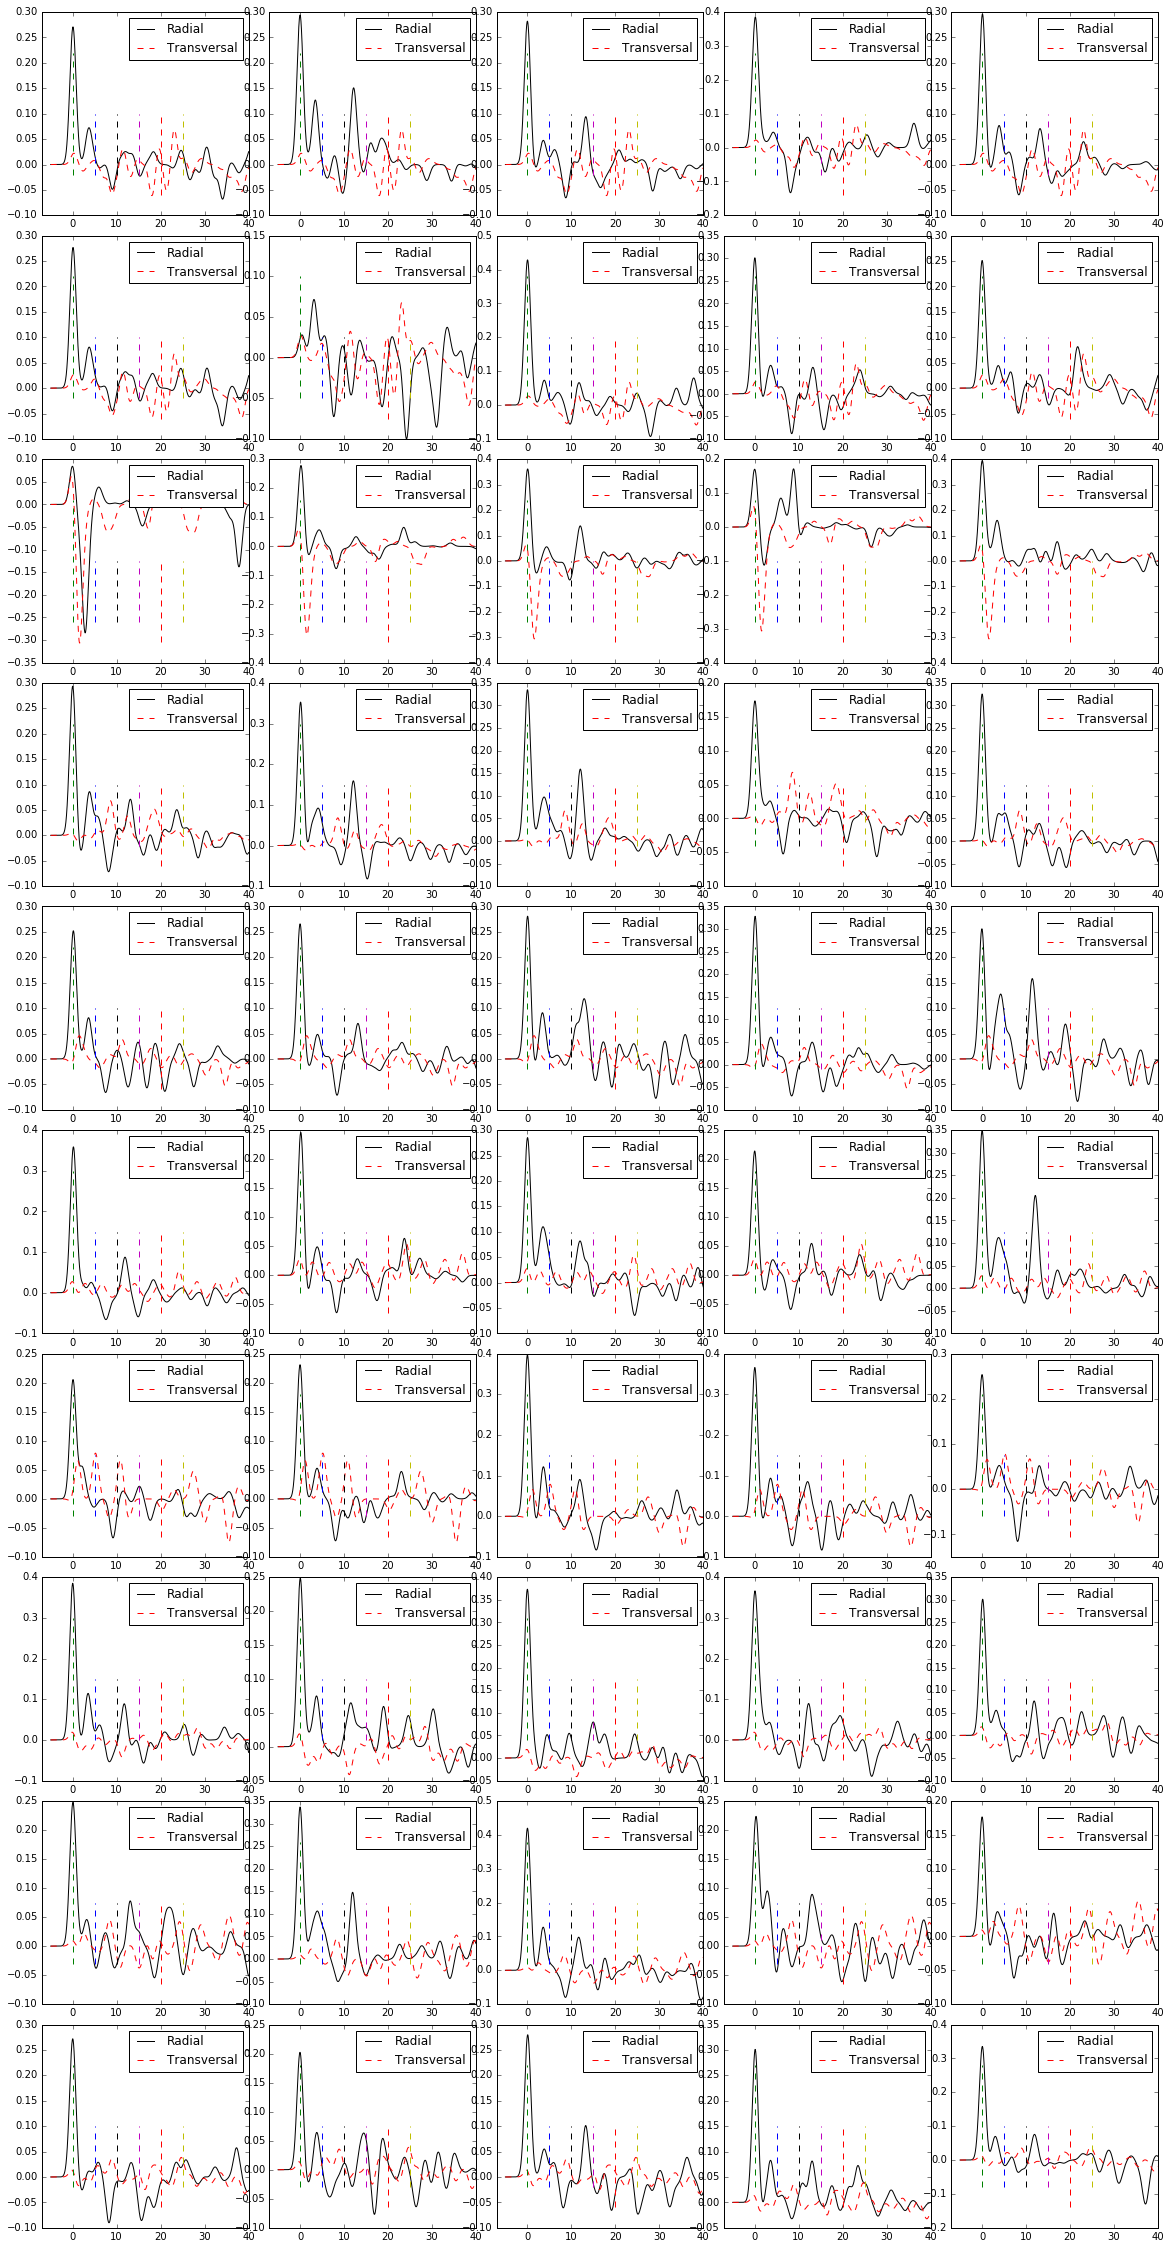

In [192]:
mpl.figure(figsize = (20,200))
gs1 = gridspec.GridSpec(len(RFRbom),len(RFRbom1))
gs1.update(wspace=0.1, hspace=0.1)
for i,j in enumerate(RFRbom1):
    for h in range(len(RFnamebom1[0])):
        ax1 = mpl.subplot(gs1[h,i])
        ax1.plot(j[h].times()-5,j[h].data,'k',label='Radial')
        ax1.plot(RFTbom1[0][h].times()-5,RFTbom1[0][h].data,'--r',label='Transversal')
        ax1.legend()
        ax1.axvline(x=0, ymin=0.2, ymax=0.8, ls='dashed',c='g')
        ax1.axvline(x=5, ymin=0.2, ymax=0.5, ls='dashed',c='b')
        ax1.axvline(x=10, ymin=0.2, ymax=0.5, ls='dashed',c='k')
        ax1.axvline(x=15, ymin=0.2, ymax=0.5, ls='dashed',c='m')
        ax1.axvline(x=20, ymin=0.1, ymax=0.5, ls='dashed',c='r')    
        ax1.axvline(x=25, ymin=0.2, ymax=0.5, ls='dashed',c='y')    
        ax1.set_xlim(-7,40)

<h3 align="center">  Filtrando as Funçoes do Receptor calculadas visualmente de acordo com sua estabilidade</h3> 

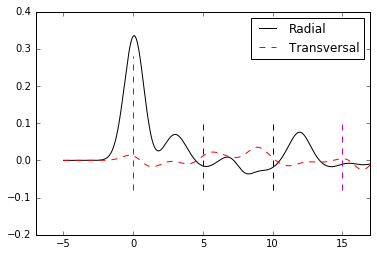

Avalie as Funçoes do Receptor (1 = Bom, 0 = Ruim) = 1


In [193]:
RFselect = []
for i,j in enumerate(RFRbom):
    mpl.plot(j.times()-5,j.data,'k',label='Radial')
    mpl.plot(RFTbom1[0][h].times()-5,RFTbom1[0][h].data,'--r',label='Transversal')
    mpl.legend()
    mpl.axvline(x=0, ymin=0.2, ymax=0.8, ls='dashed',c='g')
    mpl.axvline(x=5, ymin=0.2, ymax=0.5, ls='dashed',c='b')
    mpl.axvline(x=10, ymin=0.2, ymax=0.5, ls='dashed',c='k')
    mpl.axvline(x=15, ymin=0.2, ymax=0.5, ls='dashed',c='m')
    mpl.axvline(x=20, ymin=0.1, ymax=0.5, ls='dashed',c='r')    
    mpl.axvline(x=25, ymin=0.2, ymax=0.5, ls='dashed',c='y')    
    mpl.xlim(-7,17)
    time.sleep(1.0)
    display.clear_output(wait=True)
    mpl.show()
    RFselect += input("Avalie as Funçoes do Receptor (1 = Bom, 0 = Ruim) = ")

In [194]:

new_RFfilter = [True if x =='1' else False for x in RFselect]

new_RFRbom = list(compress(RFRbom, new_RFfilter))
new_RFTbom = list(compress(RFTbom, new_RFfilter))
new_RFbomname = list(compress(RFnamebom, new_RFfilter))

<h4>Número de Funções do Receptor Radial e Transversal selecionadas após a análise visual</h3>

In [195]:
len(new_RFRbom)

17

<h4>Númeoro de colunas para plotar as Funções do Receptor --> tem que ser um número múltiplo do total de Funções do Receptor Selecionadas</h4>

In [196]:
k = 1

<h3 align="center">  Plotando as Funçoes do Receptor filtradas de acordo com sua estabilidade</h3> 

In [197]:
new_RFRbom1 = [new_RFRbom[i:i+int(len(new_RFRbom)/k)] for i in range(0, len(new_RFRbom), int(len(new_RFRbom)/k))]
new_RFTbom1 =[new_RFTbom[i:i+int(len(new_RFRbom)/k)] for i in range(0, len(new_RFTbom), int(len(new_RFRbom)/k))]
new_RFbomname1 = [new_RFbomname[i:i+int(len(new_RFRbom)/k)] for i in range(0, len(new_RFbomname), int(len(new_RFRbom)/k))]

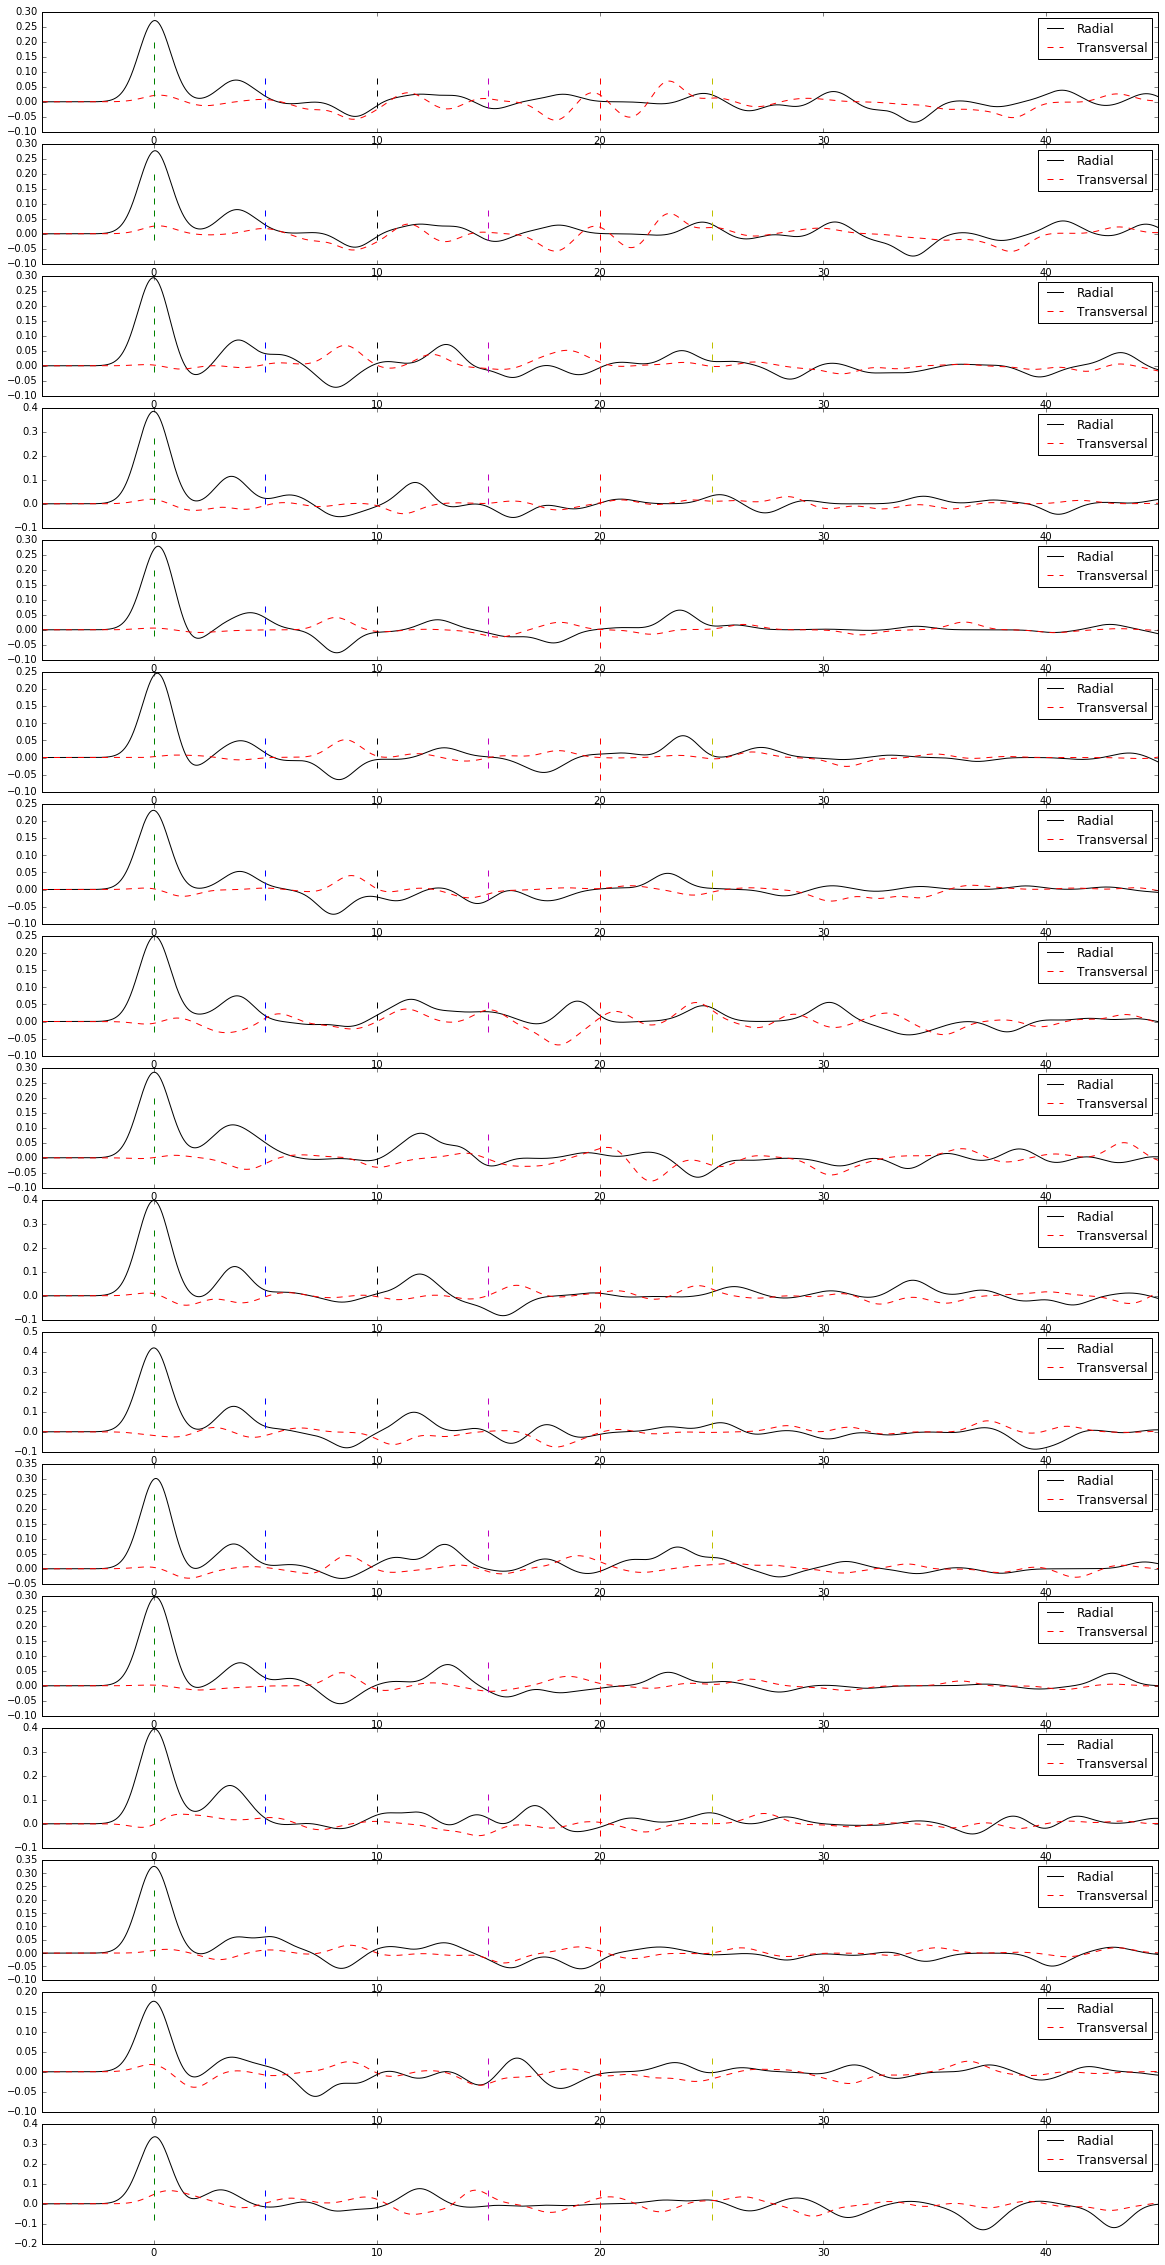

In [199]:
mpl.figure(figsize = (20,40))
gs1 = gridspec.GridSpec(len(new_RFRbom),len(new_RFRbom1))
gs1.update(wspace=0.1, hspace=0.1)
for i,j in enumerate(new_RFRbom1):
    for h in range(len(new_RFbomname1[0])):
        ax1 = mpl.subplot(gs1[h,i])
        ax1.plot(j[h].times()-5,j[h].data,'k',label='Radial')
        ax1.plot(new_RFTbom1[0][h].times()-5,new_RFTbom1[0][h].data,'--r',label='Transversal')
        ax1.legend()
        ax1.axvline(x=0, ymin=0.2, ymax=0.8, ls='dashed',c='g')
        ax1.axvline(x=5, ymin=0.2, ymax=0.5, ls='dashed',c='b')
        ax1.axvline(x=10, ymin=0.2, ymax=0.5, ls='dashed',c='k')
        ax1.axvline(x=15, ymin=0.2, ymax=0.5, ls='dashed',c='m')
        ax1.axvline(x=20, ymin=0.1, ymax=0.5, ls='dashed',c='r')    
        ax1.axvline(x=25, ymin=0.2, ymax=0.5, ls='dashed',c='y')    
        ax1.set_xlim(-5,45)

<h3 align="center">  Salvando as Funções do Receptor filtradas de acordo com sua estabilidade para fazer o HKstack</h3> 

In [200]:
os.mkdir('/home/diogo/dados_doutorado/nbla-2012/hkstack')

In [201]:
select = [i.split('.')[1:7] for i in new_RFbomname]
select_ev = ['.'.join(i) for i in select]

In [202]:
for i in select_ev:
    shutil.copy('/home/diogo/dados_doutorado/nbla-2012/'+str(i)+'/decon/Rdecon.'+str(i)+'.sac','/home/diogo/dados_doutorado/nbla-2012/hkstack/Rdecon.'+str(i)+'.sac')
    shutil.copy('/home/diogo/dados_doutorado/nbla-2012/'+str(i)+'/decon/Tdecon.'+str(i)+'.sac','/home/diogo/dados_doutorado/nbla-2012/hkstack/Tdecon.'+str(i)+'.sac')

<h3 align="center">  Criando o arquivo "list" para calcular o HKstack</h3> 

In [203]:
select_ev_list = ['Rdecon.'+str(i)+'.sac' for i in select_ev]
np.savetxt('/home/diogo/dados_doutorado/nbla-2012/hkstack/list',select_ev_list, delimiter=' ', fmt='%s')

<h1 align="center">Calculando o HK stacking para diferentes valores da velocidade da onda P ($V_{p}$)</h1>

In [5]:
os.chdir('/home/diogo/dados_doutorado/nbla-2012/hkstack/')

In [14]:
i=6.7

In [15]:
os.system('hkstack '+str(i)+' 0.5  0.5  0')
shutil.move('VALUES.TXT','vp_'+str(i)+'_VALUES.TXT')
shutil.move('pgplot.ps','vp_'+str(i)+'_pgplot.ps')

'vp_6.7_pgplot.ps'

<h3 align="center">  Construindo o gráfico para os resultados apresentados pelo HKstack para cada valor de $V_{p}$</h3> 

In [98]:
result_list = []

for root, dirs, files in os.walk('/home/diogo/dados_doutorado/nbla-2012/hkstack/'):
    for RFfile in files:
        if RFfile.startswith('vp_'):
            result_list.append(os.path.join(root, RFfile))
result_listS = sorted(result_list)

In [99]:
bs_result = []
for i in result_listS:
    bs_result.append(np.genfromtxt(i))

In [100]:
vp_vs_result = [bs_result[i][0] for i in range(len(bs_result))]
vp_vs_er_result = [bs_result[i][1] for i in range(len(bs_result))]
moho_result = [bs_result[i][2] for i in range(len(bs_result))]
moho_er_result = [bs_result[i][3] for i in range(len(bs_result))]
vp_result = ['6.3', '6.4', '6.5', '6.6', '6.7']

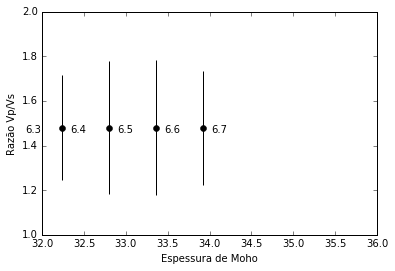

In [101]:
for i,j in enumerate(moho_result):
    mpl.plot(j,vp_vs_result[i],'ok',label=vp_result)
    mpl.text(j+0.1,vp_vs_result[i]-0.02,vp_result[i])
    mpl.vlines(j,vp_vs_result[i] - vp_vs_er_result[i],vp_vs_result[i] + vp_vs_er_result[i])
    mpl.xlim(32,36)
    mpl.ylim(1.0,2)
    mpl.ylabel('Razão Vp/Vs')
    mpl.xlabel('Espessura de Moho')

<h3 align="center">  Mostrando os resultados apresentados pelo HKstack para cada valor de $V_{p}$</h3> 

Convertendo as imagens de  .ps para .png

In [25]:
list_ps = sorted(glob.glob('*.ps'))

for file in list_ps:

    root = file[:-2]
    pdffile = root + 'pdf'
    pngfile = root + 'png'
    os.system('convert ' + file + ' ' + pngfile)

<h3> $V_{p}$ = 6.3 km/s</h3> 

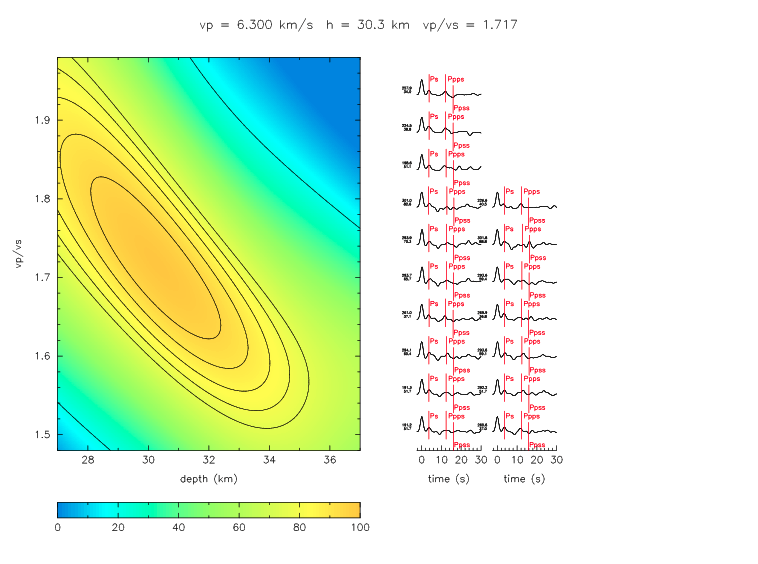

In [29]:
display.Image(filename='vp_6.3_pgplot.png')

<h3> $V_{p}$ = 6.4 km/s</h3> 

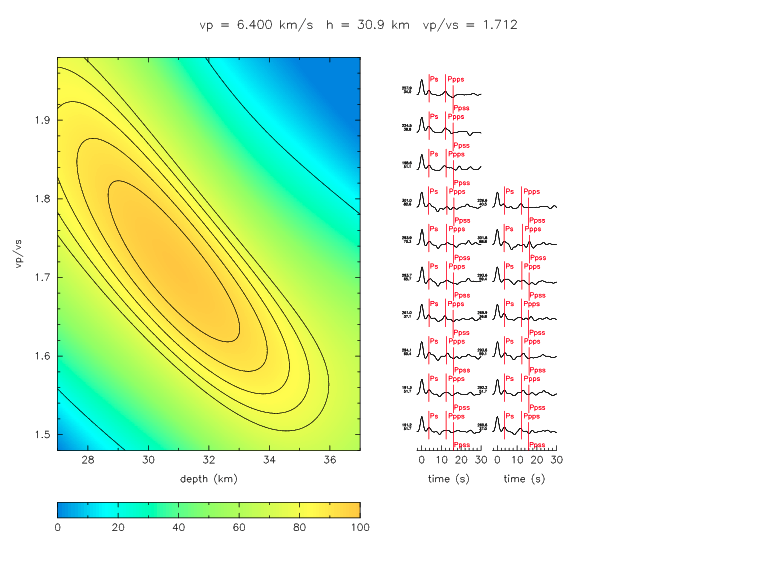

In [30]:
display.Image(filename='vp_6.4_pgplot.png')

<h3> $V_{p}$ = 6.5 km/s</h3> 

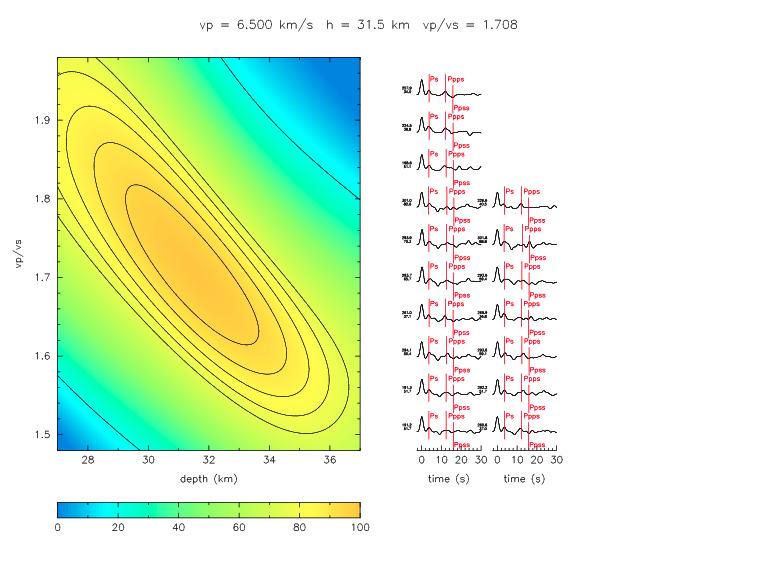

In [31]:
display.Image(filename='vp_6.5_pgplot.png')

<h3> $V_{p}$ = 6.6 km/s</h3> 

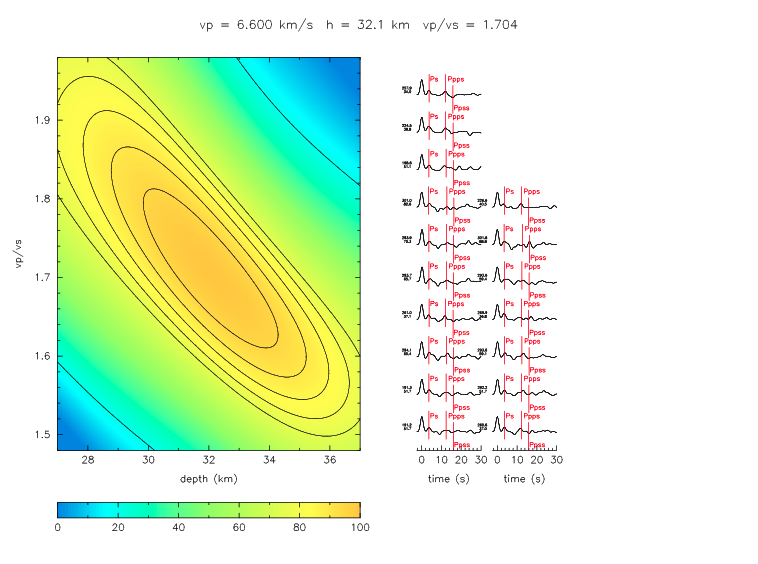

In [32]:
display.Image(filename='vp_6.6_pgplot.png')

<h3> $V_{p}$ = 6.7 km/s</h3> 

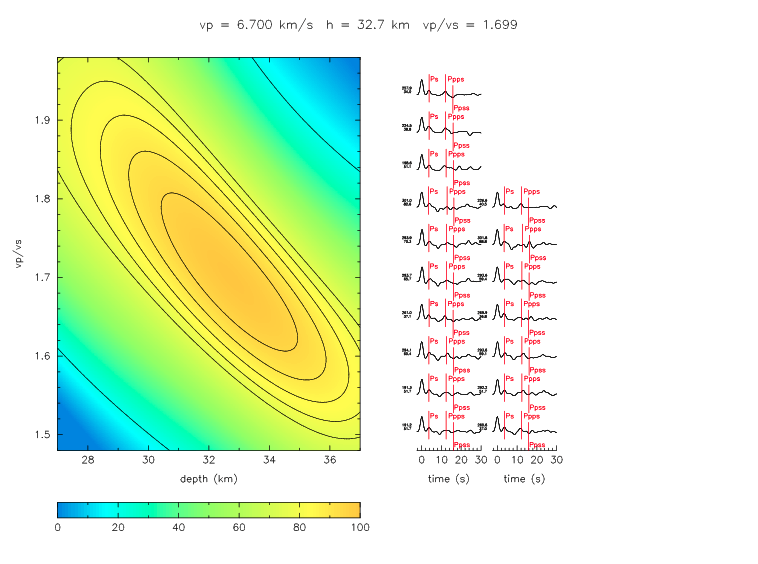

In [33]:
display.Image(filename='vp_6.7_pgplot.png')